In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
import numpy as np

data = fetch_openml('mnist_784', version=1)

## Convert your labels y into a multi-label format, by creating two columns:

    - Odd or Not: This column indicates whether the label is odd (True) or not (False).
    - Greater Than 5: This column indicates whether the label is greater than 5 (True) or not (False).

In [7]:
X, y = data["data"], data["target"]

y = y.astype(np.int8)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Odd Convert

In [8]:
y_train_odd = (y_train % 2 != 0)

## Greater than 5

In [9]:
y_train_greater_5 = (y_train > 5)

You may use np.stack() to combine your columns

In [10]:
y_multilabel = np.c_[y_train_odd, y_train_greater_5]

In [11]:
print(y_multilabel.shape)

(60000, 2)


### Model Optimization: Hyperparameter Tuning
To ensure the best possible performance for our Multi-label classifier, I implemented **GridSearchCV**. 
Instead of manually guessing the best parameters, this process systematically tests combinations of:
* `n_estimators`: The number of trees in the forest.

I will be  use **F1-Macro** as the scoring metric because it balances precision and recall across both labels (Odd and Greater than 5).

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50, 100, 200]}]
grid_search = GridSearchCV(forest, param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train[:10000], y_multilabel[:10000]) 
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'n_estimators': 200}


## Build a model that predict two labels

In [20]:
forest = RandomForestClassifier(n_estimators=200, random_state=42)
forest.fit(X_train, y_multilabel)
predictions = forest.predict(X_test)

## Use the right metrics to evaluate your model

In [16]:
from sklearn.metrics import f1_score
y_test_multilabel = np.c_[(y_test % 2 != 0), (y_test > 5)]
score = f1_score(y_test_multilabel, predictions, average="macro")
print(f"F1 Score : {score:.2f}")

F1 Score : 0.97


In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test_multilabel, predictions, target_names=['Odd', 'Greater than 5']))

                precision    recall  f1-score   support

           Odd       0.98      0.97      0.98      5074
Greater than 5       0.98      0.96      0.97      3969

     micro avg       0.98      0.97      0.97      9043
     macro avg       0.98      0.96      0.97      9043
  weighted avg       0.98      0.97      0.97      9043
   samples avg       0.68      0.68      0.68      9043



C:\Users\aottt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\aottt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\aottt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classificati

###  Performance Analysis
While the **F1-score**  is high (%97), I observed that the **Samples Average** is lower (%68). 

This difference indicates that while the model is excellent at predicting each label independently (Odd or Greater than 5), it occasionally struggles with the **Exact Match** predicting *both* labels correctly for the same image simultaneously. in multi-label learning where the model might capture one pattern (like parity) but miss the other (like magnitude) for ambiguous digits.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_multilabel)
y_knn_pred = knn_clf.predict(X_test)
print("--- KNN Multi-label Classification Report ---")
print(classification_report(y_test_multilabel, y_knn_pred))

--- KNN Multi-label Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5074
           1       0.98      0.97      0.98      3969

   micro avg       0.98      0.98      0.98      9043
   macro avg       0.98      0.98      0.98      9043
weighted avg       0.98      0.98      0.98      9043
 samples avg       0.69      0.69      0.69      9043



C:\Users\aottt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\aottt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\aottt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classificati

### KNN vs. Random Forest
After evaluating both models, **K-Neighbors Classifier (KNN)** slightly outperformed the Random Forest:
* **KNN F1:** %98 (vs %97 in RF)
* **KNN Samples Avg:** %69 (vs %68 in RF)

**Why KNN performed better?**
In MNIST, digits that look similar in the vector space tend to share the same properties. KNN excels at capturing these local spatial relationships. However, the `samples avg` remains around 0.69 for both, suggesting that the "Exact Match" challenge is inherent in the dataset's ambiguity.

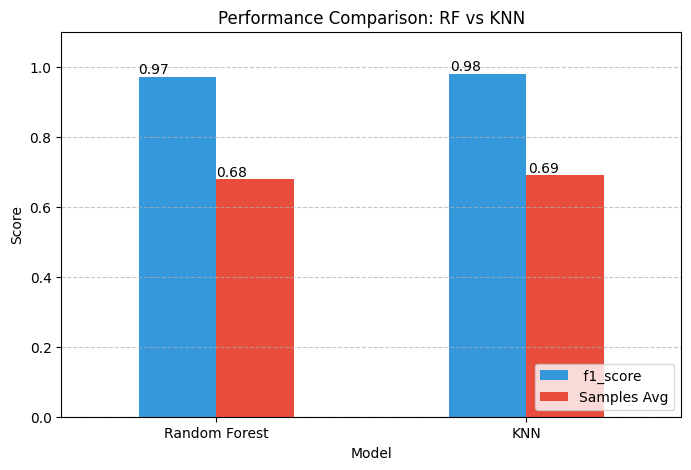

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

models = ['Random Forest', 'KNN']
macro_f1 = [0.97, 0.98] 
samples_avg = [0.68, 0.69]

df_metrics = pd.DataFrame({
    'Model': models,
    ' f1_score': macro_f1,
    'Samples Avg': samples_avg
})

ax = df_metrics.plot(x='Model', kind='bar', figsize=(8, 5), rot=0, color=['#3498db', '#e74c3c'])
plt.title('Performance Comparison: RF vs KNN')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.01))

plt.show()